# Importing Necessary libraries

In [43]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2 
import glob
import random
from os import listdir
from sklearn.metrics import classification_report
import tensorflow as tf
import keras.utils as image


# Loading Dataset

In [44]:
breast_img = glob.glob('/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive = True)

for imgname in breast_img[:3]:
    print(imgname)

/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y1101_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y501_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y1101_class0.png


# Visualizing Dataset

In [ ]:
N_IDC = []
P_IDC = []

for img in breast_img:
    if img[-5] == '0' :
        N_IDC.append(img)
    
    elif img[-5] == '1' :
        P_IDC.append(img)
plt.figure(figsize = (15, 15))

some_non = np.random.randint(0, len(N_IDC), 18)
some_can = np.random.randint(0, len(P_IDC), 18)

s = 0
for num in some_non:
    
        img = image.load_img((N_IDC[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('no cancer')
        plt.imshow(img.astype('uint8'))
        s += 1
s = 1
for num in some_can:
    
        img = image.load_img((P_IDC[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s)
        plt.axis('off')        
        plt.title('IDC (+)')
        plt.imshow(img.astype('uint8'))
        s += 1


In [88]:
print(f"Total IDC(-) images: {len(N_IDC)}")
print(f"Total IDC(+) images: {len(P_IDC)}")

Total IDC(-) images: 198738
Total IDC(+) images: 78786


# Data Preprocessing

In [90]:
# Limit to 10,000 images each
N_IDC = N_IDC[:10000]
P_IDC = P_IDC[:10000]

non_img_arr = []
can_img_arr = []

for img in N_IDC:
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    n_img_size = cv2.resize(n_img, (50, 50), interpolation=cv2.INTER_LINEAR)
    non_img_arr.append([n_img_size, 0])

for img in P_IDC:
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    c_img_size = cv2.resize(c_img, (50, 50), interpolation=cv2.INTER_LINEAR)
    can_img_arr.append([c_img_size, 1])

print(f"Processed IDC(-) images: {len(non_img_arr)}")
print(f"Processed IDC(+) images: {len(can_img_arr)}")

Processed IDC(-) images: 10000
Processed IDC(+) images: 10000


In [91]:
# Combine and shuffle the arrays
breast_img_arr = non_img_arr + can_img_arr
random.shuffle(breast_img_arr)

X = []
y = []

for feature, label in breast_img_arr:
    X.append(feature)
    y.append(label)

X = np.array(X)
y = np.array(y)

In [92]:
def describeData(a, b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b == 0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b == 1)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))

describeData(X, y)


Total number of images: 20000
Number of IDC(-) Images: 10000
Number of IDC(+) Images: 10000
Image shape (Width, Height, Channels): (50, 50, 3)


In [93]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

Y = to_categorical(y, num_classes=2)

# Split data into training, testing, and validation sets (80% train, 10% validation, 10% test)
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5)

print("Training Data Shape:", X_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Testing Data Shape:", X_test.shape)


Training Data Shape: (16000, 50, 50, 3)
Validation Data Shape: (2000, 50, 50, 3)
Testing Data Shape: (2000, 50, 50, 3)


# Modeling

In [77]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [94]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Add custom top layers
x = Flatten()(base_model.output)
x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu', kernel_initializer='he_uniform')(x)
x = Dropout(0.3)(x)
x = Dense(24, activation='relu', kernel_initializer='he_uniform')(x)
output = Dense(2, activation='softmax')(x)

ResNet50_model = Model(inputs=base_model.input, outputs=output, name="ResNet50")

for layer in base_model.layers:
    layer.trainable = False


In [95]:
ResNet50_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

ResNet50_model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 56, 56, 3)    0           ['input_8[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 25, 25, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 25, 25, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(ResNet50_model, to_file='additional_layers_model_architecture.png', show_shapes=True, show_layer_names=True)

In [97]:
history = ResNet50_model.fit(X_train, Y_train, epochs=20, batch_size=35, validation_data=(X_val, Y_val))

Epoch 1/20
458/458 [==============================] - 16s 22ms/step - loss: 0.6241 - accuracy: 0.6798 - val_loss: 0.4611 - val_accuracy: 0.7975
Epoch 2/20
458/458 [==============================] - 9s 19ms/step - loss: 0.4716 - accuracy: 0.7971 - val_loss: 0.4032 - val_accuracy: 0.8190
Epoch 3/20
458/458 [==============================] - 9s 19ms/step - loss: 0.4228 - accuracy: 0.8166 - val_loss: 0.4006 - val_accuracy: 0.8255
Epoch 4/20
458/458 [==============================] - 9s 19ms/step - loss: 0.4053 - accuracy: 0.8261 - val_loss: 0.3686 - val_accuracy: 0.8405
Epoch 5/20
458/458 [==============================] - 9s 20ms/step - loss: 0.3871 - accuracy: 0.8336 - val_loss: 0.3668 - val_accuracy: 0.8395
Epoch 6/20
458/458 [==============================] - 9s 19ms/step - loss: 0.3721 - accuracy: 0.8411 - val_loss: 0.3605 - val_accuracy: 0.8385
Epoch 7/20
458/458 [==============================] - 9s 19ms/step - loss: 0.3554 - accuracy: 0.8501 - val_loss: 0.3611 - val_accuracy: 0.843

# Model Evaluation

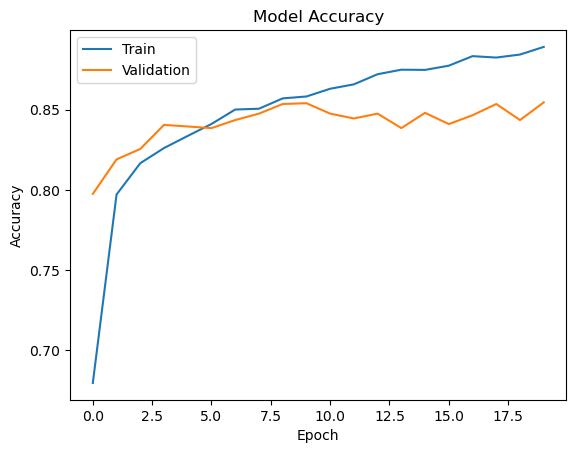

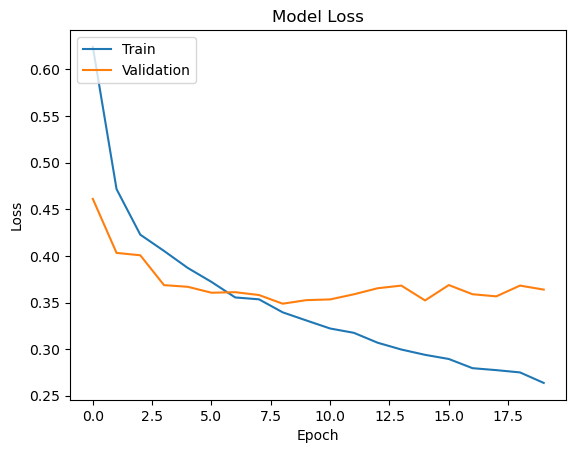

In [98]:

# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



63/63 [==============================] - 2s 13ms/step
              precision    recall  f1-score   support

     Class 0    0.79867   0.86701   0.83144       970
     Class 1    0.86378   0.79417   0.82752      1030

    accuracy                        0.82950      2000
   macro avg    0.83123   0.83059   0.82948      2000
weighted avg    0.83220   0.82950   0.82942      2000



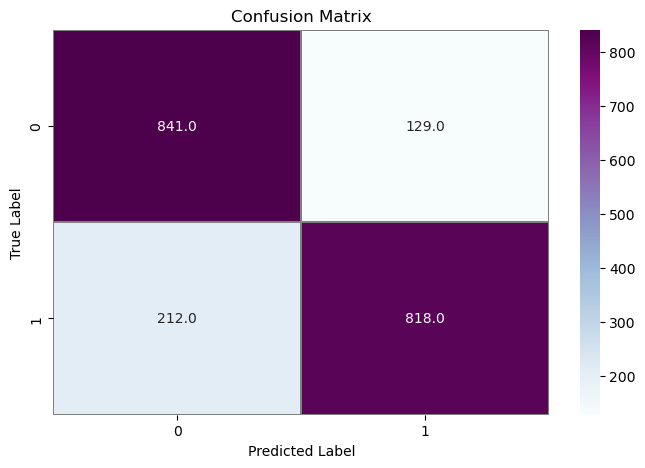

In [99]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Define class names
class_names = ['Class 0', 'Class 1']

# Predict classes for test set
Y_pred = ResNet50_model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

# Print classification report
print(classification_report(Y_true, Y_pred_classes, target_names=class_names, digits=5))

# Plot confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
plt.figure(figsize=(8, 5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()


In [101]:
ResNet50_model.evaluate(X_test,Y_test)

63/63 [==============================] - 1s 15ms/step - loss: 0.4207 - accuracy: 0.8295


[0.4207010567188263, 0.8295000195503235]

# Model Save

In [61]:
model.save("/kaggle/working/Brest CNN 2.h5")

NameError: name 'model' is not defined